<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Sigma-sweep" data-toc-modified-id="Sigma-sweep-0.1.0.1"><span class="toc-item-num">0.1.0.1&nbsp;&nbsp;</span>Sigma sweep</a></span></li><li><span><a href="#Plot-mean-success" data-toc-modified-id="Plot-mean-success-0.1.0.2"><span class="toc-item-num">0.1.0.2&nbsp;&nbsp;</span>Plot mean success</a></span></li><li><span><a href="#Plot-std-vs-sigma" data-toc-modified-id="Plot-std-vs-sigma-0.1.0.3"><span class="toc-item-num">0.1.0.3&nbsp;&nbsp;</span>Plot std vs sigma</a></span></li><li><span><a href="#Plot-persistent-times" data-toc-modified-id="Plot-persistent-times-0.1.0.4"><span class="toc-item-num">0.1.0.4&nbsp;&nbsp;</span>Plot persistent times</a></span></li><li><span><a href="#Processing-sequences" data-toc-modified-id="Processing-sequences-0.1.0.5"><span class="toc-item-num">0.1.0.5&nbsp;&nbsp;</span>Processing sequences</a></span></li><li><span><a href="#Failure-and-position-counting-plotting" data-toc-modified-id="Failure-and-position-counting-plotting-0.1.0.6"><span class="toc-item-num">0.1.0.6&nbsp;&nbsp;</span>Failure and position counting plotting</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Noise-calculations" data-toc-modified-id="Noise-calculations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Noise calculations</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Systematic</a></span></li><li><span><a href="#Comparisons" data-toc-modified-id="Comparisons-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparisons</a></span><ul class="toc-item"><li><span><a href="#$\Delta_{rest}$" data-toc-modified-id="$\Delta_{rest}$-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>$\Delta_{rest}$</a></span></li><li><span><a href="#$\Delta_{next}$" data-toc-modified-id="$\Delta_{next}$-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>$\Delta_{next}$</a></span></li><li><span><a href="#$T_{persistent}$" data-toc-modified-id="$T_{persistent}$-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>$T_{persistent}$</a></span></li><li><span><a href="#Minicolums" data-toc-modified-id="Minicolums-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Minicolums</a></span></li><li><span><a href="#Hypercolumns" data-toc-modified-id="Hypercolumns-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>Hypercolumns</a></span></li></ul></li></ul></li></ul></div>

# Preamble

In [3]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=2.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

epsilon = 10e-80
vmin = -3.0

## Functions

#### Sigma sweep

In [4]:
def run_sigma_sweep(sigma_number,
                    samples,
                    sigma_max,
                    manager,
                    T_persistence=0.050):

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    tau_s = manager.nn.tau_s
    T_recall = T_persistence * minicolumns
    T_cue = 3 * tau_s
    I_cue = 0
    nr = manager.canonical_network_representation
    diff_rest = manager.nn.w[3, 2] - manager.nn.w[4, 2]
    diff_next = manager.nn.w[2, 2] - manager.nn.w[3, 2]

    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)
    factor1 = diff_rest + diff_next
    factor2 = np.power(diff_rest / diff_next, 1.0)
    sigma_normalized = sigma_vector # * factor1

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_normalized):
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(
                manager,
                nr,
                T_recall,
                T_cue,
                remove=0.005,
                reset=True,
                empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(
                persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dictionary = {
        'manager': manager,
        'sigma_vector': sigma_vector,
        'success': successes_collection,
        'persistent times': persistent_times_collection,
        'sequences': sequence_collection,
        'T_persistence': T_persistence,
        'sigma_norm': sigma_normalized
    }

    return results_dictionary

#### Plot mean success

In [5]:
def plot_mean_success_vs_sigma(results_dictionary, index=0, label=0,                                      ax=None):
    lw = 8
    ms = 15
    alpha = 0.3
    colors = sns.color_palette()

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)

    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms,                             color=colors[index] , label=label)
    ax.fill_between(sigma_vector, mean_success - std, mean_success + std,
                    color=colors[index], alpha=alpha)
    
    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success')
    ax.legend()

    return ax

#### Plot std vs sigma

In [6]:
def plot_std_success_vs_sigma(results_dictionary, index=0, label=0,                                      ax=None):
    lw = 8
    ms = 15
    alpha = 0.3
    colors = sns.color_palette()

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)

    ax.plot(sigma_vector, std, 'o-', lw=lw, ms=ms,                             color=colors[index] , label=label)
    
    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success')
    ax.legend()

    return ax

#### Plot persistent times

In [7]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None):
    lw = 8
    ms = 15
    alpha = 0.3
    colors = sns.color_palette()

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    low = mean_persistent - std
    low[low < 0.0] = 0.0
    high = mean_persistent + std
    ax.fill_between(sigma_vector, low, high,
                    color=colors[index], alpha=alpha)

    ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.axhline(0.009, ls='--', color='red', label='limit')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence}$')
    ax.legend()
    
    return ax

#### Processing sequences


In [8]:
def process_sequence_statistics(results_dictionary):

    sequence_collection = results_dictionary['sequences']
    success_collection = results_dictionary['success']

    sigma_number =  len(sequence_collection)
    samples = len(sequence_collection[0])
    sequence_lengths = np.zeros((sigma_number, samples))
    failure_position = np.ones((sigma_number, samples)) * -1.0
    type_of_failures = np.ones((sigma_number, samples))

    for sigma_index in range(sigma_number):
        was_success = success_collection[sigma_index]
        sequences = sequence_collection[sigma_index]
        for sample_index, sequence in enumerate(sequences):
            sequence_lengths[sigma_index, sample_index] = len(sequence)
            # If the sequence was not succesfful determine the type
            if not was_success[sample_index]:
                # If the cue failed to initilize
                if sequence[0] != 0:
                    failure_position[sigma_index, sample_index] = 0
                    type_of_failures[sigma_index, sample_index] = 0             
                else:
                # Determine the position and type of the error
                    diff = np.diff(sequence)
                    failed_where = np.where(diff != 1)[0][0]
                    type_of_failure = diff[failed_where]
                    failure_position[sigma_index, sample_index] = failed_where + 1
                    type_of_failures[sigma_index, sample_index] = type_of_failure 

    # Update the dictionary
    results_dictionary['sequence lengths'] = sequence_lengths
    results_dictionary['failure position'] =  failure_position
    results_dictionary['type of failure'] = type_of_failures
    
    # Calculate how many of each failure they are
    min_failure = int(np.min(type_of_failures))
    max_failure = int(np.max(type_of_failures))
    failure_counting = {}
    for failure_number in range(min_failure, max_failure):
        failure_counting[failure_number] = np.sum(type_of_failures == failure_number,                                                         axis=1) / samples
    
    results_dictionary['failure counting'] = failure_counting
    
    # Calculate how many units fail in some particular positions
    min_position = int(np.min(failure_position))
    max_position = int(np.max(failure_position))
    position_counting = {}
    for position_number in range(min_position, max_position):
        position_counting[position_number] = np.sum(failure_position == position_number,                                                       axis=1) / samples

    results_dictionary['position counting'] = position_counting

#### Failure and position counting plotting

In [9]:
def plot_position_failure(results_dictionary, ax=None, title =' '):
    lw = 8
    ms = 15
    alpha = 0.3
    sigma_vector = results_dictionary['sigma_vector']
    position_counting = results_dictionary['position counting']
    colors = sns.color_palette(n_colors=len(position_counting))

    if ax is None:   
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for index, position in enumerate(position_counting.keys()):
        ax.plot(sigma_vector, position_counting[position], 'o-', ms=ms,                   lw=lw, color=colors[index], label=str(position))

    ax.set_ylabel(r'$\%$ of total')
    ax.set_xlabel(r'$\sigma$')
    ax.set_title('Position of failure ' + title)

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.legend()
    
    return ax

In [10]:
def plot_failure_types(results_dictionary, ax=None, title=' '):

    lw = 8
    ms = 15
    alpha = 0.3
    sigma_vector = results_dictionary['sigma_vector']
    failure_counting = results_dictionary['failure counting']
    colors = sns.color_palette(n_colors = len(failure_counting))

    
    if ax is None:   
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for index, failure_type in enumerate(failure_counting.keys()):
        ax.plot(sigma_vector, failure_counting[failure_type], 'o-', ms=ms, lw=lw, 
                color=colors[index], label=str(failure_type))

    ax.set_ylabel(r'$\%$ of total')
    ax.set_xlabel(r'$\sigma$')
    ax.set_title('Types of failures ' + title)

    ax.axhline(0, ls='--',color='gray')
    ax.axvline(0, ls='--',color='gray')
    ax.legend()
    
    return ax

# Noise calculations

## An example

[0.052000000000000005, 0.012, 0.023, 0.17300000000000001]
[0, 2, 3, 4]


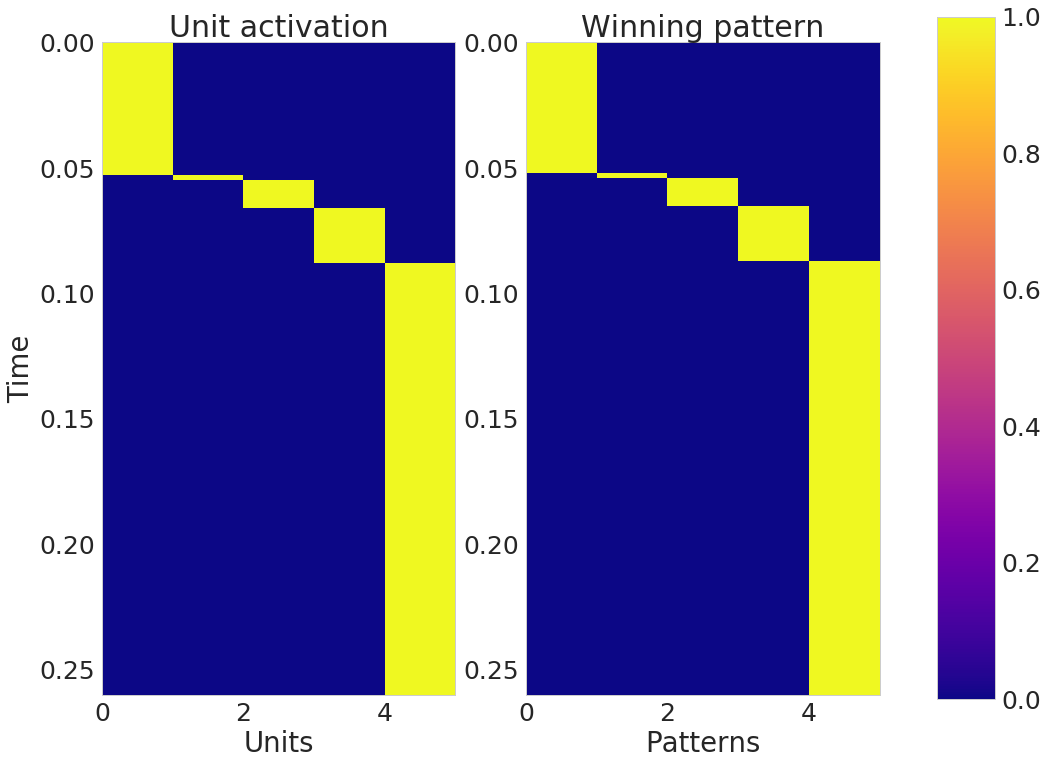

In [19]:
strict_maximum = True

g_a = 1.0
g_I = 2.0
tau_a = 0.250
G = 1.0
sigma_out = 5.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 0.5

T_persistence = 0.050


# Manager properties
dt = 0.001
values_to_save = ['o', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb ,alpha=alpha)

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
T_recall = T_persistence * minicolumns
T_cue = tau_s
I_cue = 0
nr = manager.canonical_network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux
print(persistent_times)
print(pattern_sequence)
plot_network_activity_angle(manager)

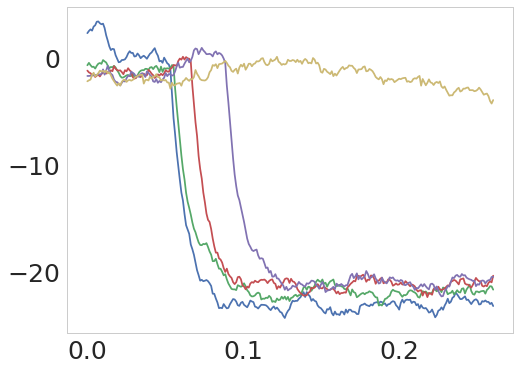

In [20]:
for i in range(5):
    plt.plot(manager.time, manager.history['s'][:, i])

## Systematic 

In [31]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 2.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 0.6
wn = 0.0
wb = -20.0
alpha = 1.8

T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post, tau_a=tau_a, 
             g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random, strict_maximum=strict_maximum, 
             perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)

sigma_number = 10
samples = 500
sigma_max = 30


results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

print(r'$\Delta w_{next}$', nn.w[1, 1] - nn.w[2, 1])
print(r'$\Delta w_{rest}$',nn.w[2, 1] - nn.w[3, 1])

$\Delta w_{next}$ 0.6
$\Delta w_{rest}$ 1.8
CPU times: user 2min 28s, sys: 20 ms, total: 2min 28s
Wall time: 2min 28s


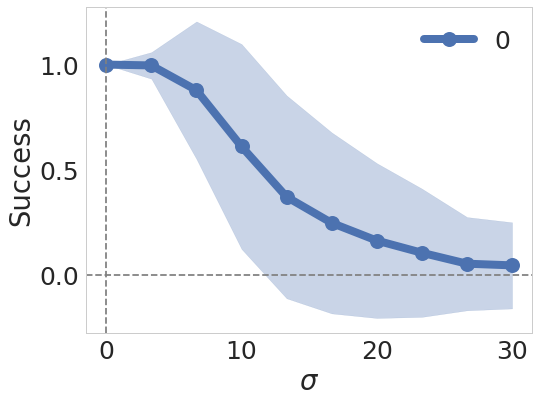

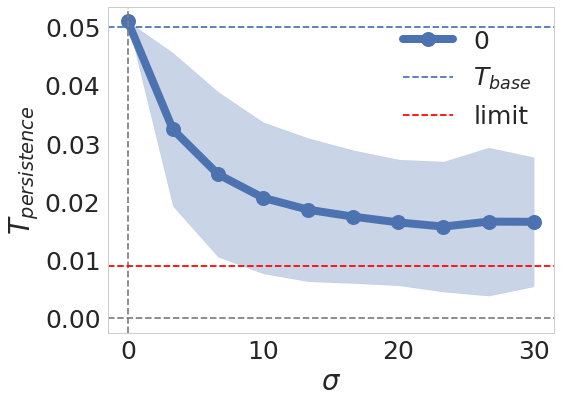

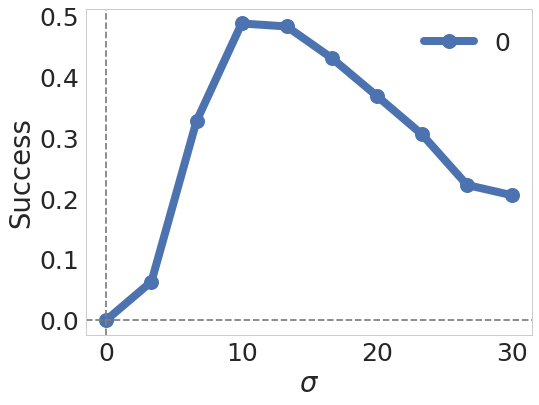

In [32]:
plot_mean_success_vs_sigma(results_dictionary, index=0, label=0, ax=None);
plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None)
plot_std_success_vs_sigma(results_dictionary, index=0, label=0, ax=None);

In [23]:
%%time
process_sequence_statistics(results_dictionary)
sequence_lengths = results_dictionary['sequence lengths'] 
failure_position = results_dictionary['failure position'] 
type_of_failures = results_dictionary['type of failure'] 
failure_counting = results_dictionary['failure counting']
position_counting = results_dictionary['position counting']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.46 ms


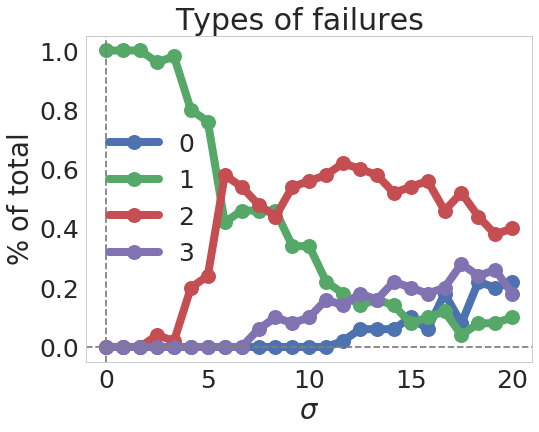

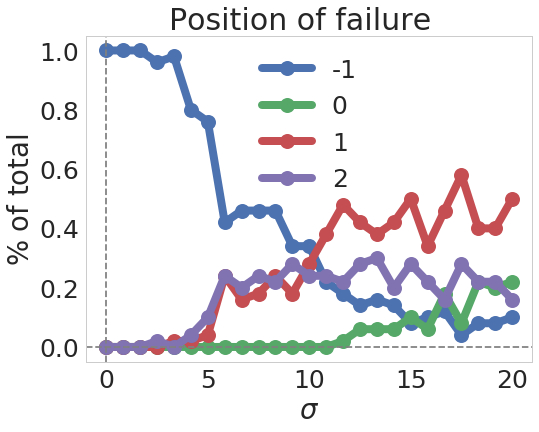

In [24]:
plot_failure_types(results_dictionary)
plot_position_failure(results_dictionary);

* **Type of failure**: indicates whether how many steps did produce the failure (2 means that it jumped one more than necessary, 1 means the right jump)
* **Position of failure**: this indicates which percentage of those recalls failed at which point. 1 for example indicates that those sequences failed when they were trying to reach the element 1 of the sequence (jumping from 0 to 1). -1 is success and 0 means a failed initialization.

## Comparisons

### $\Delta_{rest}$

In [15]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 200.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 1.0
wn = 0.0
wb = -50.0
alpha = 0.5

T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(
    hypercolumns,
    minicolumns,
    G=G,
    tau_s=tau_s,
    tau_z_pre=tau_z_pre,
    tau_z_post=tau_z_post,
    tau_a=tau_a,
    g_a=g_a,
    g_I=g_I,
    sigma_out=sigma_out,
    epsilon=epsilon,
    prng=np.random,
    strict_maximum=strict_maximum,
    perfect=False,
    normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
alphas = [0.5, 2.0, 5.0, 15.0]
results_dictionary_collection = {}
sigma_number = 15
samples = 25
sigma_max = 10

for alpha in alphas:
    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max,                                      manager, T_persistence=T_persistence)
    process_sequence_statistics(results_dictionary)
    results_dictionary_collection[alpha] = results_dictionary

CPU times: user 39.8 s, sys: 36 ms, total: 39.8 s
Wall time: 39.8 s


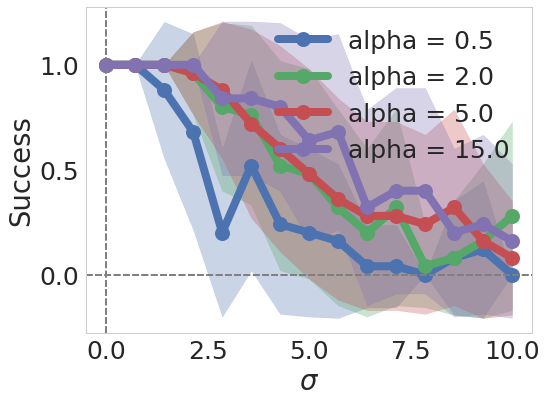

In [16]:
ax = None
for index, alpha in enumerate(alphas):
    label = 'alpha = ' + str(alpha)
    results_dictionary = results_dictionary_collection[alpha]
    ax = plot_mean_success_vs_sigma(results_dictionary, 
                                    index=index, label=label, ax=ax)


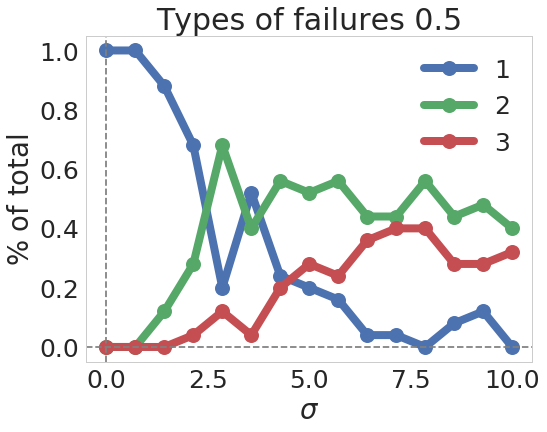

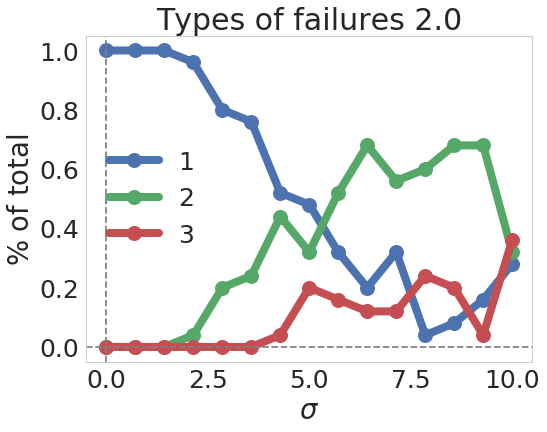

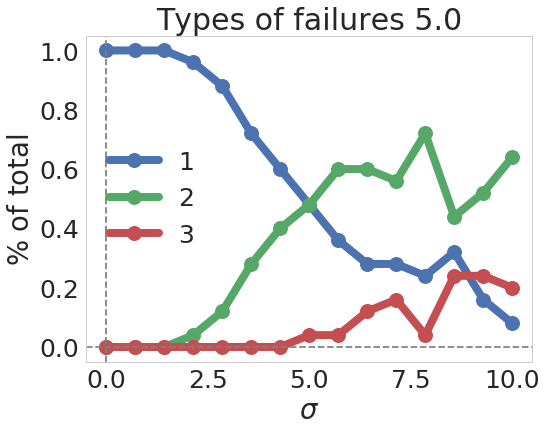

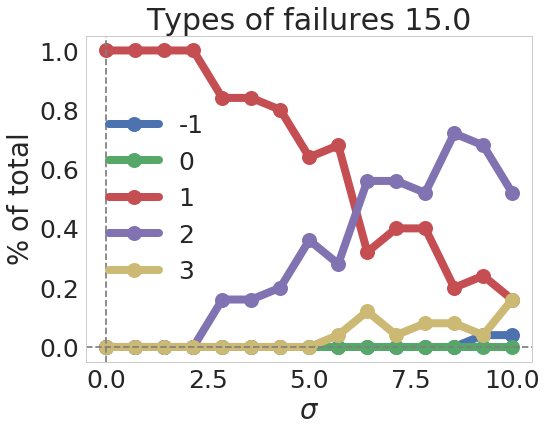

In [17]:
#%%debug
for index, alpha in enumerate(alphas):
    results_dictionary = results_dictionary_collection[alpha]
    plot_failure_types(results_dictionary, title=str(alpha))
    #plot_position_failure(results_dictionary)

### $\Delta_{next}$

In [29]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 100.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0

T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(
    hypercolumns,
    minicolumns,
    G=G,
    tau_s=tau_s,
    tau_z_pre=tau_z_pre,
    tau_z_post=tau_z_post,
    tau_a=tau_a,
    g_a=g_a,
    g_I=g_I,
    sigma_out=sigma_out,
    epsilon=epsilon,
    prng=np.random,
    strict_maximum=strict_maximum,
    perfect=False,
    normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
ws_list = [1.0, 5.0, 15.0]
results_dictionary_collection = {}
sigma_number = 15
samples = 25
sigma_max = 10

for ws in ws_list:
    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max,                                      manager, T_persistence=T_persistence)
    process_sequence_statistics(results_dictionary)
    results_dictionary_collection[ws] = results_dictionary

CPU times: user 33.9 s, sys: 68 ms, total: 34 s
Wall time: 34.2 s


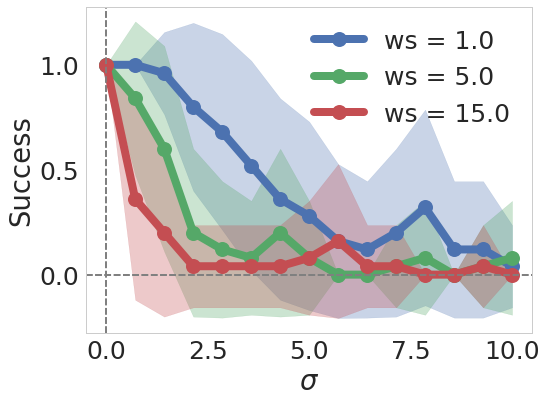

In [30]:
ax = None
for index, ws in enumerate(ws_list):
    label = 'ws = ' + str(ws)
    results_dictionary = results_dictionary_collection[ws]
    ax = plot_mean_success_vs_sigma(results_dictionary, 
                                    index=index, label=label, ax=ax)

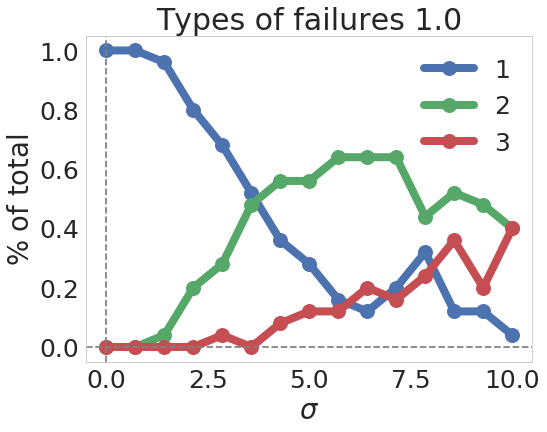

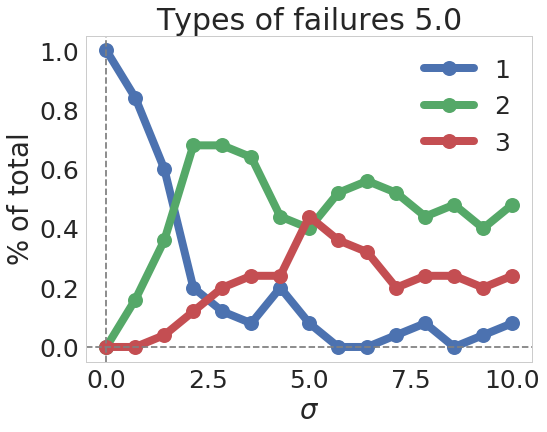

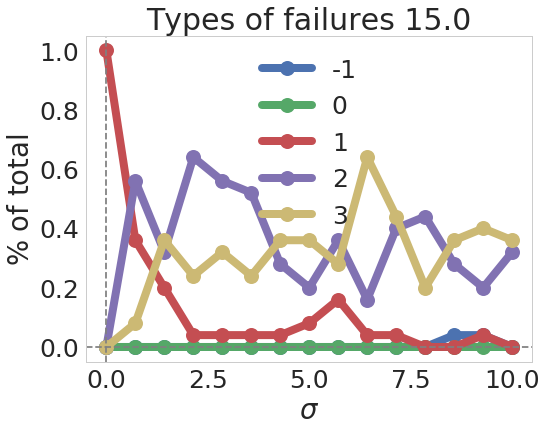

In [31]:
for index, ws in enumerate(ws_list):
    results_dictionary = results_dictionary_collection[ws]
    plot_failure_types(results_dictionary, title=str(ws))
    #plot_position_failure(results_dictionary)

### $T_{persistent}$

In [21]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 100.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0

T_persistence = 0.050

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(
    hypercolumns,
    minicolumns,
    G=G,
    tau_s=tau_s,
    tau_z_pre=tau_z_pre,
    tau_z_post=tau_z_post,
    tau_a=tau_a,
    g_a=g_a,
    g_I=g_I,
    sigma_out=sigma_out,
    epsilon=epsilon,
    prng=np.random,
    strict_maximum=strict_maximum,
    perfect=False,
    normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
Tp_list = [0.050, 0.100, 0.200]
results_dictionary_collection_tp = {}
sigma_number = 15
samples = 25
sigma_max = 10

for T_persistence in Tp_list :
    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, 
                                         manager, T_persistence=T_persistence)
    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_tp[T_persistence] = results_dictionary

CPU times: user 1min 14s, sys: 56 ms, total: 1min 14s
Wall time: 1min 14s


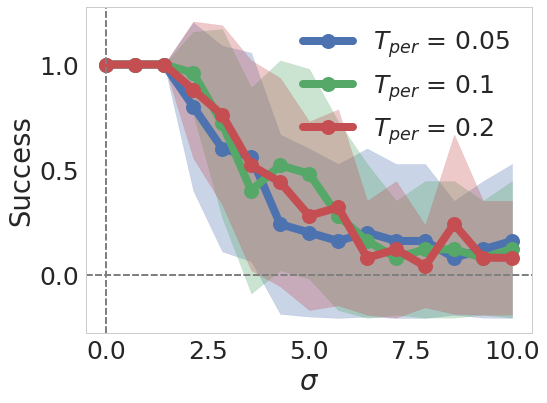

In [22]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, Tp in enumerate(Tp_list):
    label = r'$T_{per}$ = ' + str(Tp)
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_mean_success_vs_sigma(results_dictionary, 
                                    index=index, label=label, ax=ax)

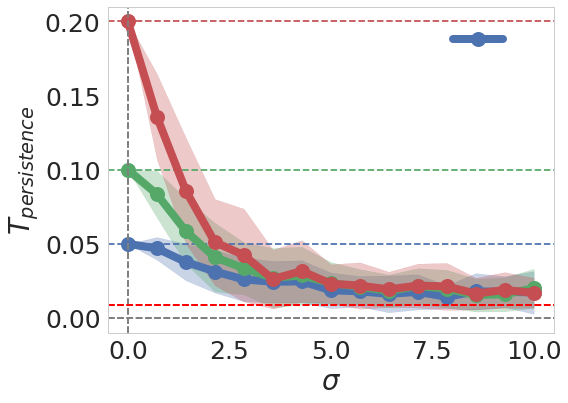

In [23]:
ax = None
parameter_list = Tp_list
for index, Tp in enumerate(parameter_list):
    label = r'$T_{per}$ = ' + str(Tp)
    results_dictionary = results_dictionary_collection[Tp]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    ax.legend([' '])

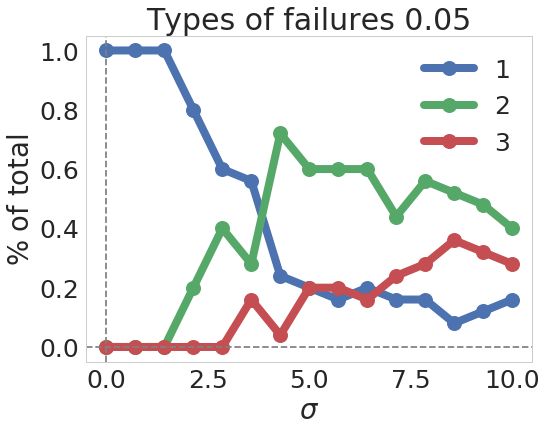

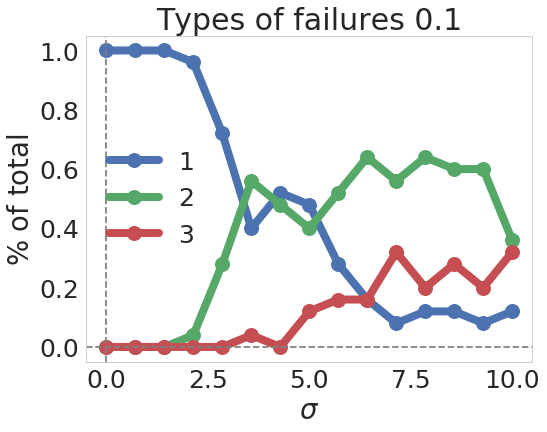

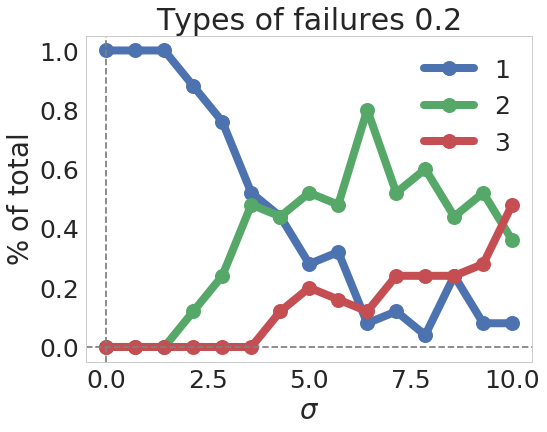

In [24]:
for index, T_persistence in enumerate(parameter_list):
    results_dictionary = results_dictionary_collection[T_persistence ]
    plot_failure_types(results_dictionary, title=str(T_persistence ))
    #plot_position_failure(results_dictionary)

### Minicolums

In [25]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 100.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0

T_persistence = 0.050


minicolumns_set = [5, 10, 20]
results_dictionary_collection_minicolumns = {}
sigma_number = 15
samples = 25
sigma_max = 10

for minicolumns in minicolumns_set:

    hypercolumns = 1
    n_patterns = minicolumns

    # Manager properties
    dt = 0.001
    values_to_save = ['o']

    # Neural Network
    nn = Network(
        hypercolumns,
        minicolumns,
        G=G,
        tau_s=tau_s,
        tau_z_pre=tau_z_pre,
        tau_z_post=tau_z_post,
        tau_a=tau_a,
        g_a=g_a,
        g_I=g_I,
        sigma_out=sigma_out,
        epsilon=epsilon,
        prng=np.random,
        strict_maximum=strict_maximum,
        perfect=False,
        normalized_currents=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)



    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, 
                                         manager, T_persistence=T_persistence)
    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_minicolumns[minicolumns] = results_dictionary

CPU times: user 2min 30s, sys: 360 ms, total: 2min 31s
Wall time: 2min 31s


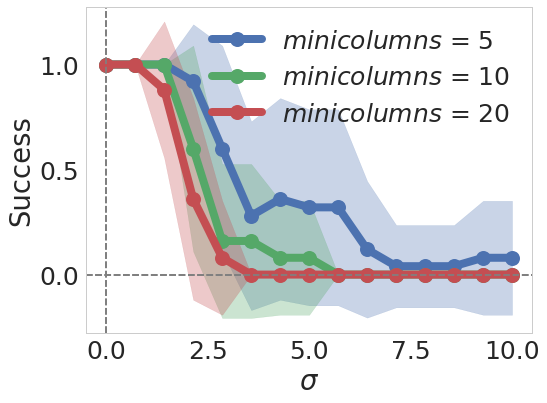

In [26]:
results_dictionary_collection = results_dictionary_collection_minicolumns
parameter_list = minicolumns_set
ax = None
for index, minicolumns in enumerate(parameter_list ):
    label = r'$minicolumns$ = ' + str(minicolumns)
    results_dictionary = results_dictionary_collection[minicolumns]
    ax = plot_mean_success_vs_sigma(results_dictionary, 
                                    index=index, label=label, ax=ax)

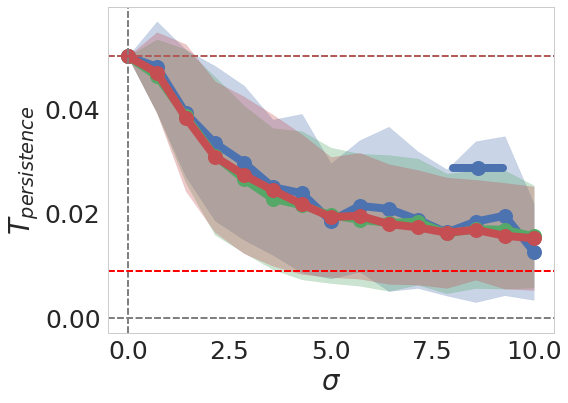

In [27]:
ax = None
parameter_list = minicolumns_set
for index, minicolumns in enumerate(parameter_list):
    label = r'$minicolumns$ = ' + str(minicolumns)
    results_dictionary = results_dictionary_collection[minicolumns]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    ax.legend([' '])

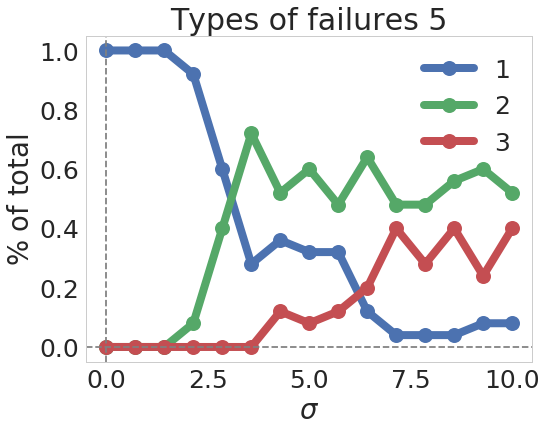

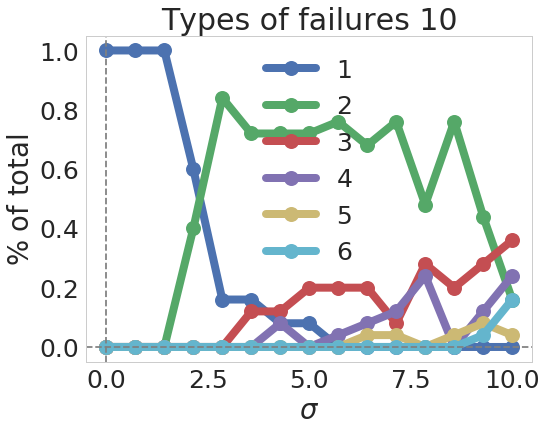

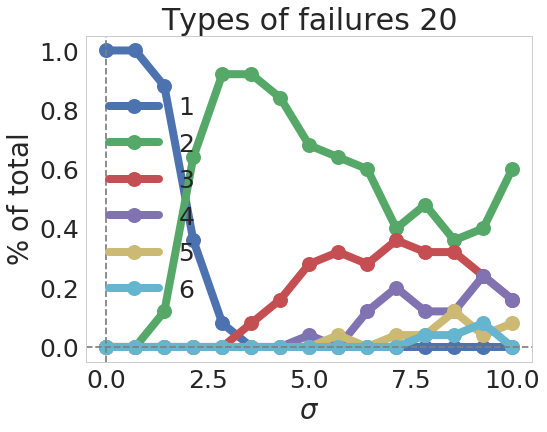

In [28]:
for index, minicolumns in enumerate(parameter_list):
    results_dictionary = results_dictionary_collection[minicolumns]
    plot_failure_types(results_dictionary, title=str(minicolumns))
    #plot_position_failure(results_dictionary)

### Hypercolumns

In [30]:
%%time
strict_maximum = True

g_a = 1.0
g_I = 100.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0

T_persistence = 0.050


hypercolumns_set = [1, 10, 100]
results_dictionary_collection_hypercolumns = {}
sigma_number = 15
samples = 25
sigma_max = 10

for hypercolumns in hypercolumns_set:

    minicolumns = 5
    n_patterns = minicolumns
    
    # Manager properties
    dt = 0.001
    values_to_save = ['o']

    # Neural Network
    nn = Network(
        hypercolumns,
        minicolumns,
        G=G,
        tau_s=tau_s,
        tau_z_pre=tau_z_pre,
        tau_z_post=tau_z_post,
        tau_a=tau_a,
        g_a=g_a,
        g_I=g_I,
        sigma_out=sigma_out,
        epsilon=epsilon,
        prng=np.random,
        strict_maximum=strict_maximum,
        perfect=False,
        normalized_currents=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)



    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb, alpha=alpha)
    results_dictionary = run_sigma_sweep(sigma_number, samples, sigma_max, 
                                         manager, T_persistence=T_persistence)
    print(manager.nn.w.shape)
    process_sequence_statistics(results_dictionary)
    results_dictionary_collection_hypercolumns[hypercolumns] = results_dictionary

(5, 5)
(50, 50)
(500, 500)
CPU times: user 1min 12s, sys: 356 ms, total: 1min 12s
Wall time: 47.6 s


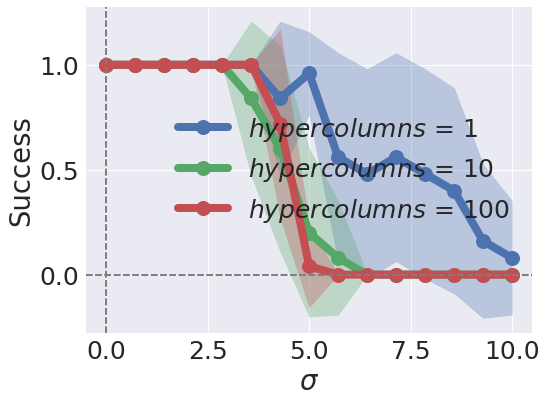

In [34]:
results_dictionary_collection = results_dictionary_collection_hypercolumns
parameter_list = hypercolumns_set
ax = None
for index, hypercolumns in enumerate(parameter_list):
    label = r'$hypercolumns$ = ' + str(hypercolumns)
    results_dictionary = results_dictionary_collection[hypercolumns]
    ax = plot_mean_success_vs_sigma(results_dictionary, 
                                    index=index, label=label, ax=ax)

In [32]:
results_dictionary_collection_hypercolumns.keys()

dict_keys([1, 10, 100])

In [33]:
hypercolumns_set

[1, 10, 100]

In [ ]:
ax = None
parameter_list = hypercolumns_set

for index, hypercolumns in enumerate(parameter_list):
    label = r'hypercolumns = ' + str(hypercolumns)
    results_dictionary = results_dictionary_collection[hypercolumns]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax)
    ax.legend()

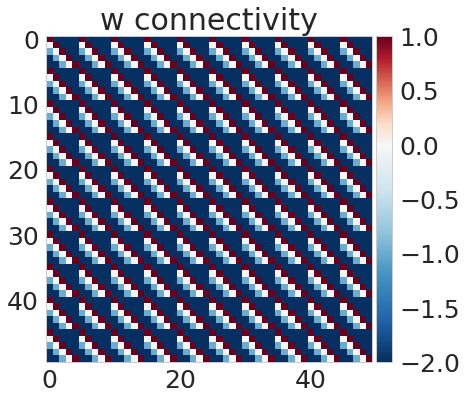

In [28]:
plot_weight_matrix(manager, one_hypercolum=False, vmin=-2.0)

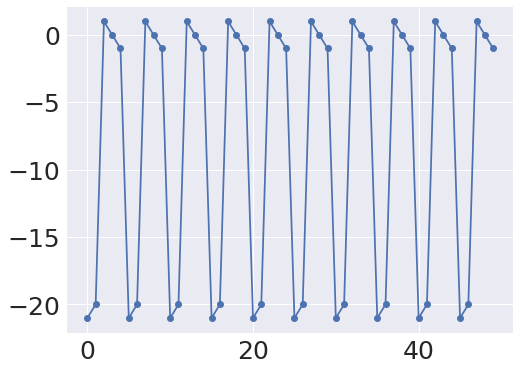

In [29]:
plt.plot(manager.nn.w[:, 2], 'o-')